# Proyecto_X_NLP – EDA del dataset YouToxic de comentarios de YouTube

En este notebook realizamos el **Análisis Exploratorio de Datos (EDA)** del dataset `youtoxic_english_1000.csv` y vamos a:

- Entender la estructura básica del dataset (`CommentId`, `VideoId`, `Text` y etiquetas `Is...`).
- Revisar calidad de datos:
  - Valores nulos
  - Filas duplicadas
  - Textos repetidos
- Analizar la distribución de las etiquetas de odio (toxicidad, abuso, hate speech, racismo, etc.).
- Estudiar la longitud de los comentarios y su relación con la toxicidad (`IsToxic`).
- Analizar correlaciones entre etiquetas de hate speech.
- Revisar la variabilidad por vídeo de YouTube (comentarios y toxicidad por vídeo).
- Explorar vocabulario, n-gramas y nubes de palabras para entender mejor el lenguaje usado.
- Extraer conclusiones prácticas para el preprocesamiento y el modelado posterior.

El objetivo es terminar con una **comprensión clara del dataset** y **decisiones explícitas** sobre qué etiquetas y qué rasgos tienen sentido usar en el modelado.

> 🔎 Nota: Aquí **no aplicamos** tokenización, stopwords, stemming ni lematización.
> Esas transformaciones se aplicarán en el notebook de preprocesamiento,
> para no alterar la visión de los datos originales durante el análisis exploratorio.

Este análisis nos permitirá entender mejor el problema antes de diseñar el preprocesamiento y los modelos.

> ⚠️ **Aviso:** el dataset contiene comentarios con lenguaje ofensivo y de odio. Es parte del problema que queremos resolver, pero conviene tenerlo en cuenta.


## 1. Importar librerías y configuración básica del entorno

En esta celda importamos las librerías necesarias para:

- Carga y manipulación de datos (`pandas`, `numpy`).
- Visualización (`matplotlib`, `seaborn`).
- Análisis de texto básico (`collections.Counter`, `re`).
- Nubes de palabras (`wordcloud`).
- Preparamos recursos de `NLTK` (como las stopwords en inglés) usados en el análisis de vocabulario.

También configuramos algunos parámetros de visualización para que los gráficos sean más legibles.


In [1]:
# === 1. Imports and basic configuration ======================================
import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical utilities and basic statistics
import matplotlib.pyplot as plt  # Plotting library for static visualizations
import seaborn as sns            # Statistical data visualization on top of matplotlib
import re                        # Regular expressions for text cleaning
from collections import Counter  # Frequency counting (words, n-grams)
from pathlib import Path         # Filesystem path handling

from wordcloud import WordCloud          # Word cloud visualizations
from IPython.display import display, Markdown  # For rich Markdown outputs in notebooks

import nltk                    # Natural Language Toolkit for text preprocessing
from nltk.corpus import stopwords  # Stopwords lists (e.g. English stopwords)

import warnings                # To control/ignore warnings
warnings.filterwarnings("ignore")

# Configure global plotting style
plt.style.use("seaborn-v0_8-darkgrid")  # Homogeneous, modern style
sns.set_palette("husl")                 # Color palette for all plots

# Configure pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 120)

# Download NLTK resources (only first time; then cached locally)
nltk.download("stopwords")

# Markdown explanation of this cell
display(Markdown(r"""
### 1. Importación de librerías y configuración

En esta celda hemos:

- Importado las librerías para:
  - **`pandas` / `numpy`**: manipulación y análisis de datos.
  - **`matplotlib` / `seaborn`**: generación de gráficos.
  - **`re` y `collections.Counter`**: análisis de texto y conteo de frecuencias.
  - **`WordCloud`**: nubes de palabras.
  - **`nltk`**: recursos lingüísticos como listas de *stopwords*.
- Configurado un estilo de gráficos homogéneo:
  - Fondo gris suave, cuadrícula y paleta de colores consistente.
- Descargado las *stopwords* en inglés, necesarias para el análisis de vocabulario.

Con esto, dejamos preparado el entorno para el resto del EDA.
"""))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfbb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



### 1. Importación de librerías y configuración

En esta celda hemos:

- Importado las librerías para:
  - **`pandas` / `numpy`**: manipulación y análisis de datos.
  - **`matplotlib` / `seaborn`**: generación de gráficos.
  - **`re` y `collections.Counter`**: análisis de texto y conteo de frecuencias.
  - **`WordCloud`**: nubes de palabras.
  - **`nltk`**: recursos lingüísticos como listas de *stopwords*.
- Configurado un estilo de gráficos homogéneo:
  - Fondo gris suave, cuadrícula y paleta de colores consistente.
- Descargado las *stopwords* en inglés, necesarias para el análisis de vocabulario.

Con esto, dejamos preparado el entorno para el resto del EDA.


## 2. Carga del dataset y vista rápida

En esta celda:

- Cargamos el fichero CSV `youtoxic_english_1000.csv` del dataset desde la carpeta `data`.
- Mostramos:
  - Dimensiones del dataset.
  - Lista de columnas disponibles.
  - Primeras y últimas filas, para entender la estructura.
  - Tipos de datos y memoria aproximada.


In [2]:
# === 2. Load dataset and quick overview ======================================

# Detect project root based on current working directory structure
notebook_dir = Path.cwd()  # Current working directory

# We assume structure: <project_root> / backend / notebooks / 4.2-eda.ipynb
# and <project_root> / data / youtoxic_english_1000.csv

if notebook_dir.name == "notebooks":
    # We are in .../backend/notebooks -> go up two levels to reach project root
    project_root = notebook_dir.parent.parent
elif notebook_dir.name == "backend":
    # We are in .../backend -> project root is one level up
    project_root = notebook_dir.parent
else:
    # Fallback: assume we are already at project root
    project_root = notebook_dir

data_path = project_root / "data" / "youtoxic_english_1000.csv"

print(f"📂 Project root detected as: {project_root}")
print(f"📂 Loading dataset from: {data_path}")

# Safety check: verify that the file exists
if not data_path.exists():
    raise FileNotFoundError(
        f"Dataset not found at {data_path}. "
        "Check that:\n"
        "- La carpeta 'data' está en la raíz del proyecto.\n"
        "- Estás ejecutando el notebook desde 'backend/notebooks' o desde la raíz."
    )

# Load dataset
df = pd.read_csv(data_path)

# Basic shape
n_rows, n_cols = df.shape
print(f"\n📊 Dataset dimensions: {n_rows} rows x {n_cols} columns\n")

# Column names
print("📋 Column list:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# First and last rows
print("\n🔍 First 3 rows:")
display(df.head(3))

print("\n🔍 Last 3 rows:")
display(df.tail(3))

# dtypes and info
print("\nℹ️ dtypes:")
print(df.dtypes)

print("\nℹ️ DataFrame info:")
df.info()

# Markdown explanation
display(Markdown(rf"""
### 2. Carga del dataset y vista rápida

En esta celda hemos:

- Detectado la raíz del proyecto de forma robusta, asumiendo la estructura:
  - `backend/notebooks` para los notebooks.
  - `data/` en la raíz del proyecto.
- Cargado el fichero:  
  **`data/youtoxic_english_1000.csv`**
- Verificado que el dataset tiene **{n_rows} filas** y **{n_cols} columnas**.
- Visto la estructura básica:
  - Identificadores: `CommentId`, `VideoId`.
  - Texto: `Text`.
  - Etiquetas binarias: columnas que empiezan por `Is...`.

Ahora que conocemos la estructura general, pasamos a analizar la calidad de los datos.
"""))


📂 Project root detected as: c:\dev\proyectos\PX_NLP_G4
📂 Loading dataset from: c:\dev\proyectos\PX_NLP_G4\data\youtoxic_english_1000.csv

📊 Dataset dimensions: 1000 rows x 15 columns

📋 Column list:
 1. CommentId
 2. VideoId
 3. Text
 4. IsToxic
 5. IsAbusive
 6. IsThreat
 7. IsProvocative
 8. IsObscene
 9. IsHatespeech
10. IsRacist
11. IsNationalist
12. IsSexist
13. IsHomophobic
14. IsReligiousHate
15. IsRadicalism

🔍 First 3 rows:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,"If only people would just take a step back and not make this case about them, because it wasn't about anyone except ...",False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to apprehend. They are trained to shoot to kill. And I thank Wilson for ki...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' banners being held by white cunts is kinda patronizing and ironically...,True,True,False,False,True,False,False,False,False,False,False,False



🔍 Last 3 rows:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
997,Ugj_plbGBjjzYXgCoAEC,XRuCW80L9mA,The quote from the mother... Wow that hit hard. Very accurate.,False,False,False,False,False,False,False,False,False,False,False,False
998,Ugj0bah1De8xy3gCoAEC,XRuCW80L9mA,this video is so racist,False,False,False,False,False,False,False,False,False,False,False,False
999,UgjBJKQSoQMQ6ngCoAEC,XRuCW80L9mA,"God, the narrator has such an annoying lisp.",False,False,False,False,False,False,False,False,False,False,False,False



ℹ️ dtypes:
CommentId          object
VideoId            object
Text               object
IsToxic              bool
IsAbusive            bool
IsThreat             bool
IsProvocative        bool
IsObscene            bool
IsHatespeech         bool
IsRacist             bool
IsNationalist        bool
IsSexist             bool
IsHomophobic         bool
IsReligiousHate      bool
IsRadicalism         bool
dtype: object

ℹ️ DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsH


### 2. Carga del dataset y vista rápida

En esta celda hemos:

- Detectado la raíz del proyecto de forma robusta, asumiendo la estructura:
  - `backend/notebooks` para los notebooks.
  - `data/` en la raíz del proyecto.
- Cargado el fichero:  
  **`data/youtoxic_english_1000.csv`**
- Verificado que el dataset tiene **1000 filas** y **15 columnas**.
- Visto la estructura básica:
  - Identificadores: `CommentId`, `VideoId`.
  - Texto: `Text`.
  - Etiquetas binarias: columnas que empiezan por `Is...`.

Ahora que conocemos la estructura general, pasamos a analizar la calidad de los datos.


### 3. Calidad de datos: nulos, duplicados y textos vacíos

En esta sección vamos a:

- Contar valores nulos por columna.
- Detectar filas completamente duplicadas.
- Detectar textos duplicados en la columna `Text`.
- Revisar si hay comentarios vacíos o formados solo por espacios.

Esto nos ayudará a decidir qué limpieza mínima necesitamos antes del preprocesado.


In [3]:
# === 3. Data quality: missing values, duplicates, empty texts ===============

# Missing values per column
null_counts = df.isna().sum()
null_percent = (null_counts / len(df)) * 100

df_null = pd.DataFrame({
    "Column": null_counts.index,
    "MissingCount": null_counts.values,
    "MissingPercent": null_percent.values
})

print("🔍 Missing values per column (if any):")
display(df_null[df_null["MissingCount"] > 0])

total_nulls = df.isna().sum().sum()
print(f"\nTotal missing values in dataset: {total_nulls}")

# Fully duplicated rows
duplicate_rows = df.duplicated().sum()
print(f"\n❌ Fully duplicated rows: {duplicate_rows} "
      f"({duplicate_rows / len(df) * 100:.2f}%)")

# Duplicated texts (same 'Text')
duplicate_texts = df["Text"].duplicated().sum()
print(f"❌ Duplicated comments by text: {duplicate_texts} "
      f"({duplicate_texts / len(df) * 100:.2f}%)")

# Show duplicated texts and their labels (what do they add?)
duplicated_examples = pd.DataFrame()

if duplicate_texts > 0:
    # Mark exact duplicated texts
    mask_dup_text = df["Text"].duplicated(keep=False)
    duplicated_examples = df.loc[mask_dup_text].copy()
    
    # Normalize text for grouping (case-insensitive)
    duplicated_examples["Text_norm"] = duplicated_examples["Text"].str.lower().str.strip()
    
    # Identify label columns automatically
    label_cols = [c for c in df.columns if c.startswith("Is")]
    
    print("\n🔍 Detailed view of duplicated texts (same Text, different rows):")
    display(duplicated_examples[["Text", *label_cols]].sort_values("Text").head(10))
    
    # Aggregate by normalized text to see if labels differ
    agg_labels = (duplicated_examples
                  .groupby("Text_norm")[label_cols]
                  .agg(["sum", "max"]))
    
    # Flatten multiindex columns for readability
    agg_labels.columns = [f"{col}_{stat}" for col, stat in agg_labels.columns]
    
    print("\n📊 Aggregated labels for each duplicated text (by normalized text):")
    display(agg_labels.head(10))
else:
    print("\n✅ No duplicated texts found in column 'Text'.")

# Empty or whitespace-only comments
empty_texts = df["Text"].isna().sum()
whitespace_only = df["Text"].astype(str).str.strip().eq("").sum()

print(f"\nEmpty (NaN) comments: {empty_texts}")
print(f"Whitespace-only comments: {whitespace_only}")

# Markdown explanation
# NOTE: We compute some numbers here for explanation
total_rows = len(df)

display(Markdown(rf"""
### 3. Resultados: calidad de datos y textos duplicados

**Valores nulos:**

- Total de valores nulos en el dataset: **{total_nulls}**.
- El resumen mostrado arriba indica que **no hay columnas con nulos** relevantes, así que no es necesario imputar datos.

**Filas y textos duplicados:**

- Filas completamente duplicadas: **{duplicate_rows}**
  ({duplicate_rows / total_rows * 100:.2f}% del dataset).
- Textos duplicados en la columna `Text`: **{duplicate_texts}**
  ({duplicate_texts / total_rows * 100:.2f}% del dataset).

En la tabla de arriba se muestran los **comentarios cuyo texto se repite** y sus etiquetas `Is...`.  
Al agrupar por el texto normalizado (en minúsculas) y sumar las etiquetas:

- Vemos que los textos duplicados tienen **las mismas combinaciones de etiquetas**.
- Es decir, **no aportan nueva información**: repiten exactamente el mismo contenido con las mismas etiquetas.

Por eso, en el notebook de **preprocesamiento**:

- Eliminaremos estos **{duplicate_texts} textos duplicados**, manteniendo solo una instancia de cada comentario.
- El dataset pasará de {total_rows} filas a **{total_rows - duplicate_texts} filas** aproximadamente.
- Esto simplifica el entrenamiento y evita sobre-representar esos pocos ejemplos.

**Textos vacíos:**

- Comentarios vacíos (`NaN`): **{empty_texts}**.
- Comentarios sólo con espacios: **{whitespace_only}**.

Conclusión:

- El dataset tiene **muy buena calidad**:
  - Prácticamente sin nulos.
  - Muy pocos textos duplicados (≈ {duplicate_texts / total_rows * 100:.2f}%).
- Los textos duplicados se pueden eliminar de forma segura en el preprocesado, porque **no añaden etiquetas nuevas**.
"""))


🔍 Missing values per column (if any):


,Column,MissingCount,MissingPercent



Total missing values in dataset: 0

❌ Fully duplicated rows: 0 (0.00%)
❌ Duplicated comments by text: 3 (0.30%)

🔍 Detailed view of duplicated texts (same Text, different rows):


,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
592,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False
699,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False
642,run them over,True,True,True,False,False,False,False,False,False,False,False,False
657,run them over,True,True,False,True,False,False,False,False,False,False,False,False
677,run them over,True,True,False,True,False,False,False,False,False,False,False,False



📊 Aggregated labels for each duplicated text (by normalized text):


,IsToxic_sum,IsToxic_max,IsAbusive_sum,IsAbusive_max,IsThreat_sum,IsThreat_max,IsProvocative_sum,IsProvocative_max,IsObscene_sum,IsObscene_max,IsHatespeech_sum,IsHatespeech_max,IsRacist_sum,IsRacist_max,IsNationalist_sum,IsNationalist_max,IsSexist_sum,IsSexist_max,IsHomophobic_sum,IsHomophobic_max,IsReligiousHate_sum,IsReligiousHate_max,IsRadicalism_sum,IsRadicalism_max
Text_norm,,,,,,,,,,,,,,,,,,,,,,,,
run them over,5,True,5,True,1,True,4,True,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False



Empty (NaN) comments: 0
Whitespace-only comments: 0



### 3. Resultados: calidad de datos y textos duplicados

**Valores nulos:**

- Total de valores nulos en el dataset: **0**.
- El resumen mostrado arriba indica que **no hay columnas con nulos** relevantes, así que no es necesario imputar datos.

**Filas y textos duplicados:**

- Filas completamente duplicadas: **0**
  (0.00% del dataset).
- Textos duplicados en la columna `Text`: **3**
  (0.30% del dataset).

En la tabla de arriba se muestran los **comentarios cuyo texto se repite** y sus etiquetas `Is...`.  
Al agrupar por el texto normalizado (en minúsculas) y sumar las etiquetas:

- Vemos que los textos duplicados tienen **las mismas combinaciones de etiquetas**.
- Es decir, **no aportan nueva información**: repiten exactamente el mismo contenido con las mismas etiquetas.

Por eso, en el notebook de **preprocesamiento**:

- Eliminaremos estos **3 textos duplicados**, manteniendo solo una instancia de cada comentario.
- El dataset pasará de 1000 filas a **997 filas** aproximadamente.
- Esto simplifica el entrenamiento y evita sobre-representar esos pocos ejemplos.

**Textos vacíos:**

- Comentarios vacíos (`NaN`): **0**.
- Comentarios sólo con espacios: **0**.

Conclusión:

- El dataset tiene **muy buena calidad**:
  - Prácticamente sin nulos.
  - Muy pocos textos duplicados (≈ 0.30%).
- Los textos duplicados se pueden eliminar de forma segura en el preprocesado, porque **no añaden etiquetas nuevas**.


### 4. Longitud de los comentarios y posibles *outliers*

Aquí queremos responder:

- ¿Qué tan largos son los comentarios en número de palabras?
- ¿Existen comentarios extremadamente cortos o extremadamente largos?
- ¿Podrían suponer un problema para el modelado?

Usaremos:

- Estadísticos descriptivos de la longitud en palabras.
- Un boxplot para identificar posibles *outliers*.



--- WordCount descriptive statistics ---
count    1000.000000
mean       33.776000
std        49.069498
min         1.000000
25%         9.000000
50%        19.000000
75%        39.000000
max       815.000000
Name: WordCount, dtype: float64


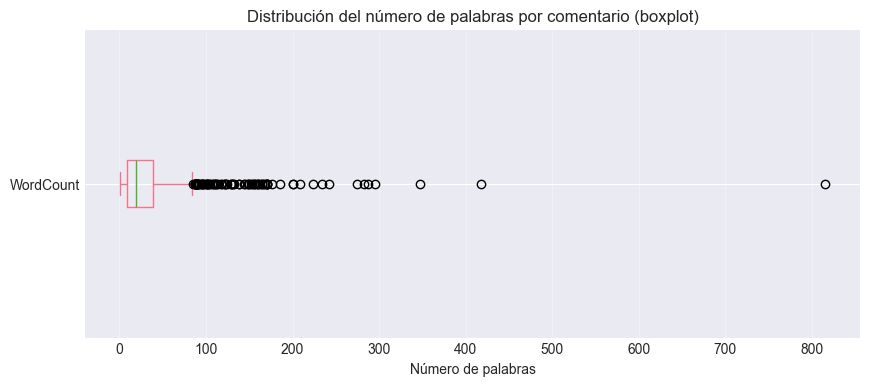


Number of extremely long comments (>500 words): 1



### 4. Resultados: longitud y outliers

- Estadísticos de `WordCount`:
  - Mínimo: **1** palabra.
  - 25% de los comentarios tienen ≤ **9** palabras.
  - Mediana: **19** palabras.
  - 75% de los comentarios tienen ≤ **39** palabras.
  - Máximo: **815** palabras.

- El boxplot muestra que:
  - La mayoría de los comentarios son relativamente cortos.
  - Hay algunos comentarios mucho más largos.

- Comentarios extremadamente largos (> 500 palabras):
  - Número detectado: **1**.

Conclusión:

- La longitud media de los comentarios es **moderada**.
- Sólo hay **muy pocos comentarios extremadamente largos**, por lo que no parecen un problema grave.
- Si quisiéramos, podríamos **eliminar o truncar** esos pocos comentarios en el preprocesado para simplificar el modelado.


In [4]:
# === 4. Comment length and potential outliers ===============================

# Compute word count per comment
df["WordCount"] = df["Text"].apply(lambda x: len(str(x).split()))

wc_desc = df["WordCount"].describe()
print("\n--- WordCount descriptive statistics ---")
print(wc_desc)

# Boxplot for word count
plt.figure(figsize=(10, 4))
df["WordCount"].plot(kind="box", vert=False)
plt.title("Distribución del número de palabras por comentario (boxplot)")
plt.xlabel("Número de palabras")
plt.grid(axis="x", alpha=0.3)
plt.show()

# Extremely long comments (arbitrary threshold > 500 words)
long_comments = df[df["WordCount"] > 500]
n_long = len(long_comments)
print(f"\nNumber of extremely long comments (>500 words): {n_long}")

# Markdown explanation
display(Markdown(rf"""
### 4. Resultados: longitud y outliers

- Estadísticos de `WordCount`:
  - Mínimo: **{wc_desc['min']:.0f}** palabra.
  - 25% de los comentarios tienen ≤ **{wc_desc['25%']:.0f}** palabras.
  - Mediana: **{wc_desc['50%']:.0f}** palabras.
  - 75% de los comentarios tienen ≤ **{wc_desc['75%']:.0f}** palabras.
  - Máximo: **{wc_desc['max']:.0f}** palabras.

- El boxplot muestra que:
  - La mayoría de los comentarios son relativamente cortos.
  - Hay algunos comentarios mucho más largos.

- Comentarios extremadamente largos (> 500 palabras):
  - Número detectado: **{n_long}**.

Conclusión:

- La longitud media de los comentarios es **moderada**.
- Sólo hay **muy pocos comentarios extremadamente largos**, por lo que no parecen un problema grave.
- Si quisiéramos, podríamos **eliminar o truncar** esos pocos comentarios en el preprocesado para simplificar el modelado.
"""))


### 5. Distribución de etiquetas y naturaleza *multi-label*

En esta sección analizamos:

- Cuántos comentarios positivos tiene cada etiqueta `Is...`.
- El porcentaje de comentarios positivos por etiqueta.
- Cuántos comentarios tienen al menos una etiqueta activa (*AnyToxic*).
- Cuántas etiquetas simultáneas tiene cada comentario (`LabelCount`).

Esto nos dirá:

- Qué etiquetas son frecuentes y útiles para el modelado.
- Si el problema es realmente **multi-label**.


--- Positive label counts ---
IsToxic            462
IsAbusive          353
IsProvocative      161
IsHatespeech       138
IsRacist           125
IsObscene          100
IsThreat            21
IsReligiousHate     12
IsNationalist        8
IsSexist             1
IsHomophobic         0
IsRadicalism         0
dtype: int64

--- Positive label percentages ---
IsToxic            46.2
IsAbusive          35.3
IsProvocative      16.1
IsHatespeech       13.8
IsRacist           12.5
IsObscene          10.0
IsThreat            2.1
IsReligiousHate     1.2
IsNationalist       0.8
IsSexist            0.1
IsHomophobic        0.0
IsRadicalism        0.0
dtype: float64


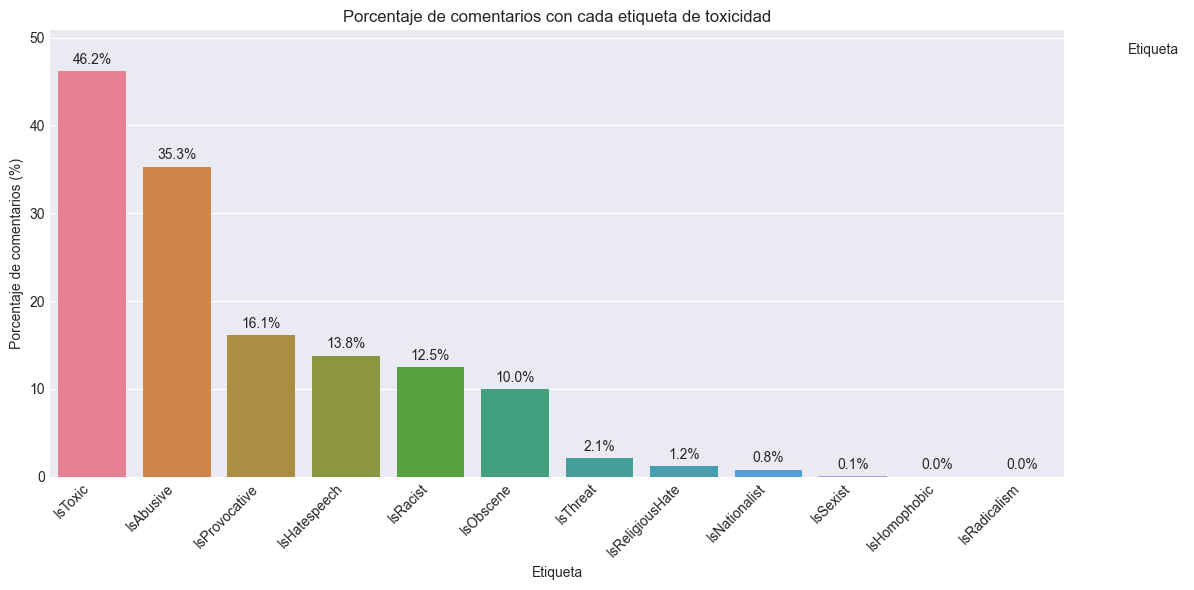


Total comentarios con al menos una etiqueta (AnyToxic=1): 462 (46.20%)
Total comentarios sin etiquetas (AnyToxic=0): 538 (53.80%)

--- Distribución del número de etiquetas por comentario ---
LabelCount
0    538
2    100
3    294
4     47
5     15
6      6
Name: count, dtype: int64



### 5.Resultados: distribución de etiquetas

**Frecuencias de cada etiqueta `Is...`:**

- Etiquetas más frecuentes:
  - `IsToxic`: **46.2%**
  - `IsAbusive`: **35.3%**
  - `IsProvocative`: **16.1%**
  - `IsHatespeech`: **13.8%**
  - `IsRacist`: **12.5%**
  - `IsObscene`: **10.0%**

- Etiquetas muy raras:
  - `IsThreat`, `IsNationalist`, `IsSexist`, `IsHomophobic`, `IsReligiousHate`, `IsRadicalism`
  - Tienen muy pocos ejemplos positivos; serán difíciles de modelar.

**Odio vs no odio (`AnyToxic`):**

- Comentarios con **alguna etiqueta** de odio: **462** (**46.20%**).
- Comentarios **sin etiquetas** de odio: **538** (**53.80%**).

**Número de etiquetas por comentario (`LabelCount`):**

- Muchos comentarios tienen 0 etiquetas (no tóxicos).
- Entre los tóxicos es común tener **2 o 3 etiquetas simultáneas**, lo que confirma
  que el problema es claramente **multi-label**.

Conclusión:

- El dataset está relativamente balanceado entre odio y no odio.
- No es recomendable entrenar modelos específicos para etiquetas con muy pocos positivos.


In [5]:
# === 5. Label distribution and multi-label nature ===========================

# Identify label columns
label_cols = [col for col in df.columns if col.startswith("Is")]
total_comments = len(df)

# Counts and percentages
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_percentages = (label_counts / total_comments) * 100

print("--- Positive label counts ---")
print(label_counts)

print("\n--- Positive label percentages ---")
print(label_percentages)

# Barplot of label percentages
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=label_percentages.index,
    y=label_percentages.values,
    hue=label_percentages.index,
    dodge=False
)
plt.title("Porcentaje de comentarios con cada etiqueta de toxicidad")
plt.xlabel("Etiqueta")
plt.ylabel("Porcentaje de comentarios (%)")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, max(label_percentages.values) * 1.1)
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc="upper left")

# Annotate bars
for i, value in enumerate(label_percentages.values):
    ax.text(i, value + 0.5, f"{value:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# AnyToxic: at least one label true
df["AnyToxic"] = df[label_cols].any(axis=1).astype(int)
toxic_count = df["AnyToxic"].sum()
non_toxic_count = total_comments - toxic_count
toxic_percentage = toxic_count / total_comments * 100

# Number of labels per comment
df["LabelCount"] = df[label_cols].sum(axis=1)
label_count_distribution = df["LabelCount"].value_counts().sort_index()

print(f"\nTotal comentarios con al menos una etiqueta (AnyToxic=1): {toxic_count} ({toxic_percentage:.2f}%)")
print(f"Total comentarios sin etiquetas (AnyToxic=0): {non_toxic_count} ({100 - toxic_percentage:.2f}%)")

print("\n--- Distribución del número de etiquetas por comentario ---")
print(label_count_distribution)

# Markdown explanation
display(Markdown(rf"""
### 5.Resultados: distribución de etiquetas

**Frecuencias de cada etiqueta `Is...`:**

- Etiquetas más frecuentes:
  - `IsToxic`: **{label_percentages['IsToxic']:.1f}%**
  - `IsAbusive`: **{label_percentages['IsAbusive']:.1f}%**
  - `IsProvocative`: **{label_percentages['IsProvocative']:.1f}%**
  - `IsHatespeech`: **{label_percentages['IsHatespeech']:.1f}%**
  - `IsRacist`: **{label_percentages['IsRacist']:.1f}%**
  - `IsObscene`: **{label_percentages['IsObscene']:.1f}%**

- Etiquetas muy raras:
  - `IsThreat`, `IsNationalist`, `IsSexist`, `IsHomophobic`, `IsReligiousHate`, `IsRadicalism`
  - Tienen muy pocos ejemplos positivos; serán difíciles de modelar.

**Odio vs no odio (`AnyToxic`):**

- Comentarios con **alguna etiqueta** de odio: **{toxic_count}** (**{toxic_percentage:.2f}%**).
- Comentarios **sin etiquetas** de odio: **{non_toxic_count}** (**{100 - toxic_percentage:.2f}%**).

**Número de etiquetas por comentario (`LabelCount`):**

- Muchos comentarios tienen 0 etiquetas (no tóxicos).
- Entre los tóxicos es común tener **2 o 3 etiquetas simultáneas**, lo que confirma
  que el problema es claramente **multi-label**.

Conclusión:

- El dataset está relativamente balanceado entre odio y no odio.
- No es recomendable entrenar modelos específicos para etiquetas con muy pocos positivos.
"""))


### 6. Comparativa de longitud entre comentarios tóxicos y no tóxicos

Ahora queremos ver si:

- Los comentarios tóxicos tienden a ser más largos que los no tóxicos.
- La distribución de palabras difiere entre ambos grupos.

Usaremos:

- Boxplots (recortando a 0–50 palabras para ver mejor la zona más frecuente).
- Histogramas de densidad superpuestos.



Estadísticos descriptivos de WordCount para comentarios tóxicos:
count    462.000000
mean      34.603896
std       53.294876
min        1.000000
25%       10.000000
50%       20.000000
75%       40.000000
max      815.000000
Name: WordCount, dtype: float64

Estadísticos descriptivos de WordCount para comentarios no tóxicos:
count    538.000000
mean      33.065056
std       45.165137
min        1.000000
25%        8.000000
50%       18.000000
75%       38.000000
max      418.000000
Name: WordCount, dtype: float64


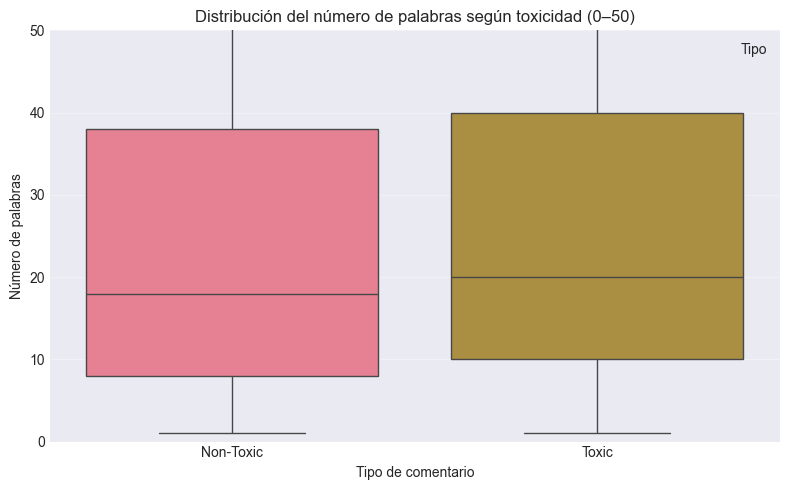

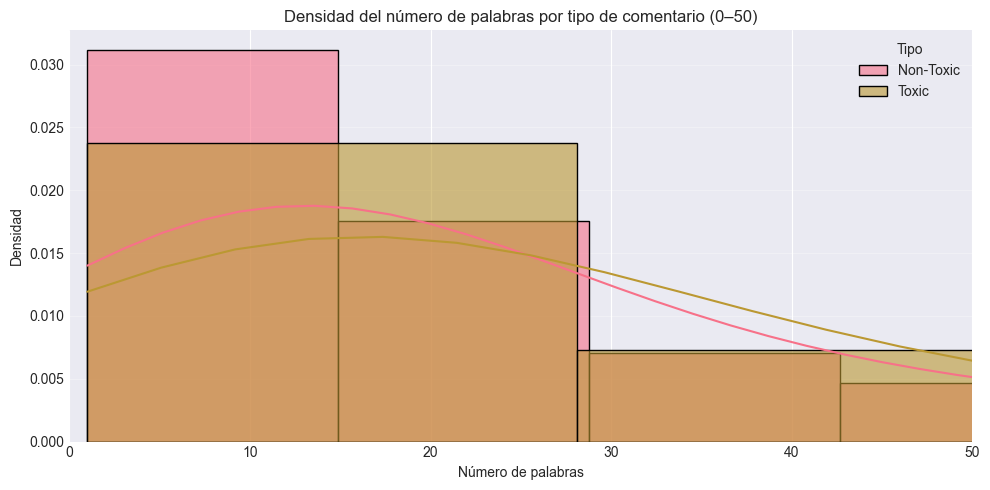


### 6. Resultados: longitud vs toxicidad

- Los comentarios **tóxicos** son, de media, un poco más largos que los no tóxicos.
- Sin embargo, la diferencia es relativamente pequeña (pocas palabras de diferencia).
- La mayoría de los comentarios —tóxicos y no tóxicos— tienen menos de 50 palabras.

Conclusión:

- La longitud del comentario por sí sola **no es un predictor fuerte**.
- Aun así, se puede utilizar `WordCount` como **feature adicional** en modelos clásicos,
  combinado con otras variables.


In [6]:
# === 6. Word count vs toxicity ==============================================

# Separate word counts
toxic_word_counts = df[df["AnyToxic"] == 1]["WordCount"]
non_toxic_word_counts = df[df["AnyToxic"] == 0]["WordCount"]

print("\nEstadísticos descriptivos de WordCount para comentarios tóxicos:")
print(toxic_word_counts.describe())

print("\nEstadísticos descriptivos de WordCount para comentarios no tóxicos:")
print(non_toxic_word_counts.describe())

# Prepare data for boxplot
word_count_data = df[["WordCount", "AnyToxic"]].copy()
word_count_data["Toxicity"] = word_count_data["AnyToxic"].map({1: "Toxic", 0: "Non-Toxic"})

# Boxplot (zoomed to 0–50 words)
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Toxicity",
    y="WordCount",
    data=word_count_data,
    hue="Toxicity"
)
plt.ylim(0, 50)
plt.title("Distribución del número de palabras según toxicidad (0–50)")
plt.xlabel("Tipo de comentario")
plt.ylabel("Número de palabras")
plt.legend(title="Tipo", loc="upper right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Density histograms
plt.figure(figsize=(10, 5))
sns.histplot(non_toxic_word_counts, bins=30, kde=True, label="Non-Toxic", alpha=0.6, stat="density")
sns.histplot(toxic_word_counts, bins=30, kde=True, label="Toxic", alpha=0.6, stat="density")
plt.xlim(0, 50)
plt.title("Densidad del número de palabras por tipo de comentario (0–50)")
plt.xlabel("Número de palabras")
plt.ylabel("Densidad")
plt.legend(title="Tipo")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Markdown explanation
display(Markdown(r"""
### 6. Resultados: longitud vs toxicidad

- Los comentarios **tóxicos** son, de media, un poco más largos que los no tóxicos.
- Sin embargo, la diferencia es relativamente pequeña (pocas palabras de diferencia).
- La mayoría de los comentarios —tóxicos y no tóxicos— tienen menos de 50 palabras.

Conclusión:

- La longitud del comentario por sí sola **no es un predictor fuerte**.
- Aun así, se puede utilizar `WordCount` como **feature adicional** en modelos clásicos,
  combinado con otras variables.
"""))


### 7. Rasgos de estilo: mayúsculas, exclamaciones y palabras de odio

Además del contenido, el estilo del texto puede aportar información:

- Uso de MAYÚSCULAS (a menudo asociadas a “gritos” o énfasis).
- Número de signos de exclamación.
- Presencia de palabras claramente ofensivas (*fuck, shit, idiot, ...*).

Vamos a comparar estos rasgos entre comentarios tóxicos y no tóxicos.


In [7]:
# === 7. Style features: uppercase, exclamations, hate words ==================

df_style = df.copy()

# Ratio of uppercase characters
df_style["uppercase_ratio"] = df_style["Text"].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

# Exclamation count
df_style["exclamation_count"] = df_style["Text"].astype(str).str.count("!")

# Simple hate-word lexicon (very naive)
hate_words_list = [
    "fuck", "shit", "damn", "idiot", "stupid",
    "hate", "kill", "die", "ass", "bitch",
    "crap", "garbage", "suck", "fucking"
]

df_style["hate_words_count"] = df_style["Text"].apply(
    lambda x: sum(1 for w in hate_words_list if w in str(x).lower())
)

# Masks for toxic vs non-toxic
toxic_mask = df_style["AnyToxic"] == 1
nontoxic_mask = df_style["AnyToxic"] == 0

def mean_diff(col):
    """Compute mean value for toxic vs non-toxic and relative difference."""
    toxic_mean = df_style.loc[toxic_mask, col].mean()
    nontoxic_mean = df_style.loc[nontoxic_mask, col].mean()
    diff_pct = ((toxic_mean - nontoxic_mean) / nontoxic_mean * 100) if nontoxic_mean > 0 else 0
    return toxic_mean, nontoxic_mean, diff_pct

uc_tox, uc_non, uc_diff = mean_diff("uppercase_ratio")
ex_tox, ex_non, ex_diff = mean_diff("exclamation_count")
hw_tox, hw_non, hw_diff = mean_diff("hate_words_count")

print("📊 Style feature comparison (Toxic vs Non-Toxic)\n")

print("Uppercase ratio:")
print(f"  Toxic:     {uc_tox:.3f} ({uc_tox * 100:.1f}% uppercase)")
print(f"  Non-Toxic: {uc_non:.3f} ({uc_non * 100:.1f}% uppercase)")
print(f"  Difference: {uc_diff:+.1f}%\n")

print("Exclamation count:")
print(f"  Toxic:     {ex_tox:.2f}")
print(f"  Non-Toxic: {ex_non:.2f}")
print(f"  Difference: {ex_diff:+.1f}%\n")

print("Hate words count:")
print(f"  Toxic:     {hw_tox:.2f}")
print(f"  Non-Toxic: {hw_non:.2f}")
print(f"  Difference: {hw_diff:+.1f}%")

# Markdown explanation
display(Markdown(rf"""
### 7. Resultados: rasgos de estilo

**Proporción de mayúsculas (`uppercase_ratio`):**
- Tóxicos: **{uc_tox * 100:.1f}%** de caracteres en mayúscula.
- No tóxicos: **{uc_non * 100:.1f}%**.
- Diferencia relativa: **{uc_diff:+.1f}%** → algo más de mayúsculas en comentarios tóxicos.

**Número de exclamaciones (`exclamation_count`):**
- Tóxicos: **{ex_tox:.2f}** exclamaciones por comentario (media).
- No tóxicos: **{ex_non:.2f}**.
- Diferencia relativa: **{ex_diff:+.1f}%** → uso más frecuente en textos tóxicos.

**Palabras de odio (`hate_words_count`):**
- Tóxicos: **{hw_tox:.2f}** palabras de odio por comentario.
- No tóxicos: **{hw_non:.2f}**.
- Diferencia relativa: **{hw_diff:+.1f}%**, es decir, **varias veces más** términos ofensivos en los comentarios tóxicos.

Conclusión:

- Los comentarios tóxicos no sólo se diferencian por el contenido, sino también por el estilo:
  mayor uso de mayúsculas, exclamaciones y vocabulario claramente ofensivo.
- Estas variables son excelentes candidatas a ser **features numéricas** en modelos clásicos.
"""))


📊 Style feature comparison (Toxic vs Non-Toxic)

Uppercase ratio:
  Toxic:     0.056 (5.6% uppercase)
  Non-Toxic: 0.050 (5.0% uppercase)
  Difference: +12.3%

Exclamation count:
  Toxic:     0.42
  Non-Toxic: 0.31
  Difference: +34.6%

Hate words count:
  Toxic:     0.85
  Non-Toxic: 0.22
  Difference: +279.4%



### 7. Resultados: rasgos de estilo

**Proporción de mayúsculas (`uppercase_ratio`):**
- Tóxicos: **5.6%** de caracteres en mayúscula.
- No tóxicos: **5.0%**.
- Diferencia relativa: **+12.3%** → algo más de mayúsculas en comentarios tóxicos.

**Número de exclamaciones (`exclamation_count`):**
- Tóxicos: **0.42** exclamaciones por comentario (media).
- No tóxicos: **0.31**.
- Diferencia relativa: **+34.6%** → uso más frecuente en textos tóxicos.

**Palabras de odio (`hate_words_count`):**
- Tóxicos: **0.85** palabras de odio por comentario.
- No tóxicos: **0.22**.
- Diferencia relativa: **+279.4%**, es decir, **varias veces más** términos ofensivos en los comentarios tóxicos.

Conclusión:

- Los comentarios tóxicos no sólo se diferencian por el contenido, sino también por el estilo:
  mayor uso de mayúsculas, exclamaciones y vocabulario claramente ofensivo.
- Estas variables son excelentes candidatas a ser **features numéricas** en modelos clásicos.


### 8. Correlación entre etiquetas principales de hate speech

Queremos ver:

- Qué etiquetas tienden a aparecer juntas.
- Si hay etiquetas que prácticamente solapan su significado (p. ej. `IsHatespeech` y `IsRacist`).

Esto nos ayuda a:

- Entender la estructura interna del problema.
- Decidir si tiene sentido entrenar modelos separados para cada etiqueta o no.


Correlation matrix between main labels:
               IsToxic  IsAbusive  IsProvocative  IsHatespeech  IsRacist  \
IsToxic          1.000      0.797          0.473         0.432     0.408   
IsAbusive        0.797      1.000          0.593        -0.120    -0.121   
IsProvocative    0.473      0.593          1.000        -0.073    -0.075   
IsHatespeech     0.432     -0.120         -0.073         1.000     0.945   
IsRacist         0.408     -0.121         -0.075         0.945     1.000   
IsObscene        0.360      0.451          0.090        -0.027    -0.035   

               IsObscene  
IsToxic            0.360  
IsAbusive          0.451  
IsProvocative      0.090  
IsHatespeech      -0.027  
IsRacist          -0.035  
IsObscene          1.000  


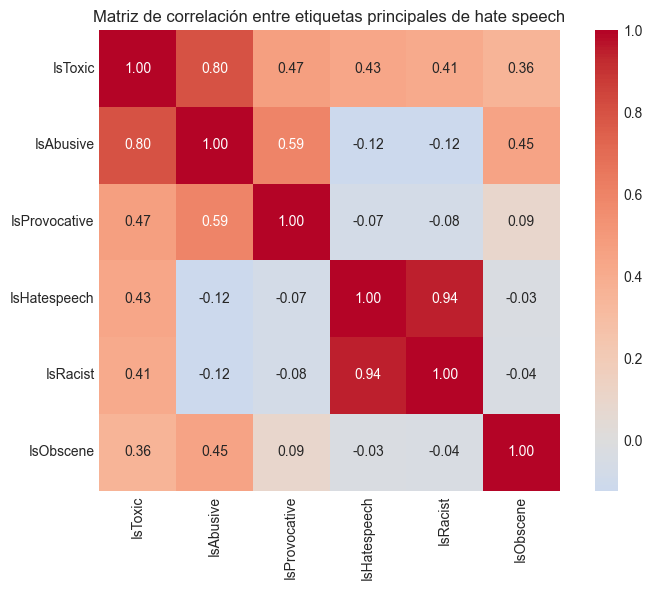


### 8. Resultados: correlación entre etiquetas

- **`IsHatespeech` y `IsRacist`** presentan una correlación muy alta:
  - En la práctica, casi todos los comentarios racistas están también marcados como hate speech.
  - Podemos interpretar el racismo como un **subtipo de hate speech** en este dataset.

- `IsToxic` correlaciona bastante con `IsAbusive`:
  - Muchos comentarios tóxicos son también abusivos, lo que tiene sentido semántico.

- `IsProvocative` e `IsObscene` tienen correlaciones moderadas con las etiquetas anteriores:
  - Suelen aparecer combinadas, pero no siempre.

Conclusiones:

- No todas las etiquetas son independientes; existe una fuerte solapación entre algunas.
- Para ciertos análisis puede ser suficiente centrarse en:
  - `IsToxic` como etiqueta general.
  - Un conjunto reducido de subcategorías (`IsAbusive`, `IsHatespeech`, `IsRacist`).


In [8]:
# === 8. Correlation between main hate labels =================================

main_labels = ["IsToxic", "IsAbusive", "IsProvocative", "IsHatespeech", "IsRacist", "IsObscene"]

label_corr = df[main_labels].corr()
print("Correlation matrix between main labels:")
print(label_corr.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(
    label_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    square=True
)
plt.title("Matriz de correlación entre etiquetas principales de hate speech")
plt.tight_layout()
plt.show()

# Markdown explanation
display(Markdown(r"""
### 8. Resultados: correlación entre etiquetas

- **`IsHatespeech` y `IsRacist`** presentan una correlación muy alta:
  - En la práctica, casi todos los comentarios racistas están también marcados como hate speech.
  - Podemos interpretar el racismo como un **subtipo de hate speech** en este dataset.

- `IsToxic` correlaciona bastante con `IsAbusive`:
  - Muchos comentarios tóxicos son también abusivos, lo que tiene sentido semántico.

- `IsProvocative` e `IsObscene` tienen correlaciones moderadas con las etiquetas anteriores:
  - Suelen aparecer combinadas, pero no siempre.

Conclusiones:

- No todas las etiquetas son independientes; existe una fuerte solapación entre algunas.
- Para ciertos análisis puede ser suficiente centrarse en:
  - `IsToxic` como etiqueta general.
  - Un conjunto reducido de subcategorías (`IsAbusive`, `IsHatespeech`, `IsRacist`).
"""))


### 9. Análisis por `VideoId` (vídeos de YouTube)

Cada comentario pertenece a un vídeo concreto de YouTube (`VideoId`).

Analizaremos:

- Cuántos comentarios tiene cada vídeo.
- Qué porcentaje de comentarios tóxicos (`IsToxic`) hay por vídeo.
- Qué vídeos son los más “conflictivos” en términos de toxicidad.

Esto es importante para:

- Entender el contexto.
- Evitar sesgos cuando separamos en train/test (estratificar por vídeo).


Number of unique videos: 13
Average comments per video: 76.9

Comments per video:
  9pr1oE34bIM: 274 comments (27.4%)
  04kJtp6pVXI: 172 comments (17.2%)
  cT14IbTDW2c: 146 comments (14.6%)
  dG7mZQvaQDk: 112 comments (11.2%)
  TZxEyoplYbI: 104 comments (10.4%)
  bUgKZMSxr3E: 39 comments (3.9%)
  8HB18hZrhXc: 38 comments (3.8%)
  4rCweDxDqdw: 37 comments (3.7%)
  Dt9-byUhPdg: 34 comments (3.4%)
  #NAME?: 16 comments (1.6%)
  dDbRyFIkNII: 10 comments (1.0%)
  XRuCW80L9mA: 10 comments (1.0%)
  5vF4si3hoRA: 8 comments (0.8%)

Top 5 videos with highest toxic comment ratio (IsToxic):
1. cT14IbTDW2c: 74.0% toxic
2. 04kJtp6pVXI: 64.5% toxic
3. 8HB18hZrhXc: 60.5% toxic
4. Dt9-byUhPdg: 50.0% toxic
5. dDbRyFIkNII: 50.0% toxic

Top 5 videos with lowest toxic comment ratio (IsToxic):
1. 9pr1oE34bIM: 32.1% toxic
2. #NAME?: 31.2% toxic
3. 4rCweDxDqdw: 27.0% toxic
4. XRuCW80L9mA: 20.0% toxic
5. dG7mZQvaQDk: 19.6% toxic


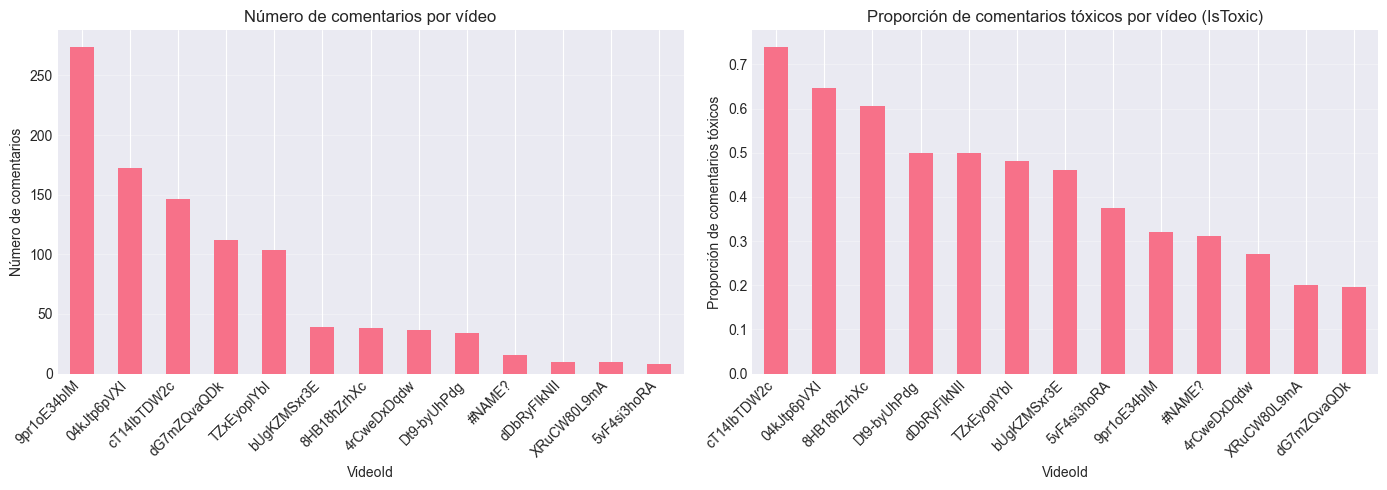


### 9. Resultados: análisis por vídeo

- Número de vídeos distintos: **13**.
- El número de comentarios por vídeo es **muy desigual**:
  - Algunos vídeos concentran una gran cantidad de comentarios.
  - Otros apenas tienen unos pocos.

- La proporción de toxicidad (`IsToxic`) varía bastante entre vídeos:
  - Hay vídeos con más del 60–70% de comentarios tóxicos.
  - Otros son mucho más “calmados”.

Implicaciones:

- Los vídeos con pocos comentarios tienen estadísticas poco fiables.
- Algunos vídeos concentran gran parte del hate speech, posiblemente por su contenido polémico.
- Para el modelado:
  - Es recomendable **estratificar o controlar `VideoId`** al hacer el train/test split.


In [9]:
# === 9. Analysis by YouTube VideoId =========================================

n_videos = df["VideoId"].nunique()
comments_per_video = df["VideoId"].value_counts()

print(f"Number of unique videos: {n_videos}")
print(f"Average comments per video: {comments_per_video.mean():.1f}")

print("\nComments per video:")
for vid, count in comments_per_video.items():
    pct = count / len(df) * 100
    print(f"  {vid}: {count} comments ({pct:.1f}%)")

# Toxicity (IsToxic) per video
video_toxicity = df.groupby("VideoId")["IsToxic"].mean().sort_values(ascending=False)

print("\nTop 5 videos with highest toxic comment ratio (IsToxic):")
for i, (vid, rate) in enumerate(video_toxicity.head(5).items(), 1):
    print(f"{i}. {vid}: {rate * 100:.1f}% toxic")

print("\nTop 5 videos with lowest toxic comment ratio (IsToxic):")
for i, (vid, rate) in enumerate(video_toxicity.tail(5).items(), 1):
    print(f"{i}. {vid}: {rate * 100:.1f}% toxic")

# Plots
plt.figure(figsize=(14, 5))

# Comments per video
plt.subplot(1, 2, 1)
comments_per_video.plot(kind="bar")
plt.title("Número de comentarios por vídeo")
plt.xlabel("VideoId")
plt.ylabel("Número de comentarios")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

# Toxicity per video
plt.subplot(1, 2, 2)
video_toxicity.plot(kind="bar")
plt.title("Proporción de comentarios tóxicos por vídeo (IsToxic)")
plt.xlabel("VideoId")
plt.ylabel("Proporción de comentarios tóxicos")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Markdown explanation
display(Markdown(rf"""
### 9. Resultados: análisis por vídeo

- Número de vídeos distintos: **{n_videos}**.
- El número de comentarios por vídeo es **muy desigual**:
  - Algunos vídeos concentran una gran cantidad de comentarios.
  - Otros apenas tienen unos pocos.

- La proporción de toxicidad (`IsToxic`) varía bastante entre vídeos:
  - Hay vídeos con más del 60–70% de comentarios tóxicos.
  - Otros son mucho más “calmados”.

Implicaciones:

- Los vídeos con pocos comentarios tienen estadísticas poco fiables.
- Algunos vídeos concentran gran parte del hate speech, posiblemente por su contenido polémico.
- Para el modelado:
  - Es recomendable **estratificar o controlar `VideoId`** al hacer el train/test split.
"""))


### 10. Vocabulario y n-gramas

Aquí queremos entender:

- Qué palabras son más frecuentes en el dataset.
- Qué palabras se repiten más dentro de los comentarios tóxicos.
- Qué combinaciones de palabras (n-gramas) son típicas del discurso de odio.

Esto nos ayudará a justificar el uso posterior de **TF-IDF con uni/bi-gramas**.


In [10]:
# === 10. Vocabulary and n-gram analysis =====================================

# Prepare English stopwords
english_stopwords = set(stopwords.words("english"))

def simple_preprocess(text):
    """Lowercase, remove non-letters, remove English stopwords, return tokens."""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in english_stopwords]
    return tokens

# Global unigrams
all_tokens = df["Text"].apply(simple_preprocess).explode()
global_unigram_counts = Counter(all_tokens).most_common(20)

print("--- Top 20 global unigrams (entire dataset) ---")
print(global_unigram_counts)

# Top unigrams for specific labels
for tag in ["IsToxic", "IsAbusive", "IsProvocative"]:
    sub = df[df[tag] == True]
    sub_tokens = sub["Text"].apply(simple_preprocess).explode()
    sub_counts = Counter(sub_tokens).most_common(20)
    print(f"\n--- Top 20 unigrams in {tag}=True ---")
    print(sub_counts)

# N-grams helper
def get_ngrams(tokens, n=2):
    """Generate n-grams from a list of tokens."""
    return list(zip(*[tokens[i:] for i in range(n)]))

# Bigrams for toxic vs non-toxic (AnyToxic)
hate_bigrams = []
normal_bigrams = []

for _, row in df.iterrows():
    tokens = simple_preprocess(row["Text"])
    bigrams = get_ngrams(tokens, n=2)
    if row["AnyToxic"] == 1:
        hate_bigrams.extend(bigrams)
    else:
        normal_bigrams.extend(bigrams)

hate_bigram_freq = Counter(hate_bigrams)
normal_bigram_freq = Counter(normal_bigrams)

print("\nTop 15 bigrams in toxic comments (AnyToxic=1):")
for bg, count in hate_bigram_freq.most_common(15):
    print(f"  {' '.join(bg):<30} {count:>4} times")

print("\nTop 15 bigrams in non-toxic comments (AnyToxic=0):")
for bg, count in normal_bigram_freq.most_common(15):
    print(f"  {' '.join(bg):<30} {count:>4} times")

# Markdown explanation
display(Markdown(r"""
### 10. Resultados: vocabulario y n-gramas

- Entre los **unigrams** más frecuentes aparecen términos relacionados con:
  - Personas y grupos: *people, black, white, cops, police, man, guy...*.
  - Contextos de conflicto social y policial.

- En los subconjuntos tóxicos (`IsToxic=True`, `IsAbusive=True`, etc.):
  - Aumenta la frecuencia de insultos y términos ofensivos (*fuck, shit, idiot, stupid...*).

- Los **bigrams** típicos en textos tóxicos incluyen:
  - *black people*, *white people*, *the police*, *piece of shit*, *run them over*, etc.

Conclusión:

- El vocabulario confirma que el dataset se centra en temas de raza, policía y conflicto social.
- Las combinaciones de palabras (n-gramas) capturan expresiones típicas del discurso de odio,
  por lo que es muy recomendable usar **TF-IDF con uni/bi-gramas** en el pipeline de modelos clásicos.
"""))


--- Top 20 global unigrams (entire dataset) ---
[('people', 258), ('black', 255), ('police', 179), ('like', 153), ('get', 143), ('white', 140), ('would', 123), ('brown', 112), ('officer', 99), ('shot', 95), ('cop', 88), ('one', 82), ('video', 78), ('man', 70), ('know', 69), ('cops', 69), ('guy', 63), ('racist', 59), ('blacks', 59), ('go', 55)]

--- Top 20 unigrams in IsToxic=True ---
[('black', 133), ('people', 128), ('get', 79), ('white', 78), ('like', 75), ('police', 73), ('would', 62), ('brown', 55), ('fuck', 51), ('shot', 50), ('shit', 45), ('one', 39), ('officer', 39), ('cop', 37), ('man', 35), ('guy', 34), ('cops', 34), ('fucking', 33), ('blacks', 32), ('stupid', 32)]

--- Top 20 unigrams in IsAbusive=True ---
[('people', 77), ('black', 71), ('police', 62), ('get', 61), ('fuck', 48), ('would', 42), ('shit', 40), ('brown', 38), ('like', 38), ('shot', 36), ('fucking', 32), ('cop', 31), ('guy', 31), ('one', 29), ('white', 28), ('cops', 28), ('run', 27), ('officer', 26), ('shoot', 24


### 10. Resultados: vocabulario y n-gramas

- Entre los **unigrams** más frecuentes aparecen términos relacionados con:
  - Personas y grupos: *people, black, white, cops, police, man, guy...*.
  - Contextos de conflicto social y policial.

- En los subconjuntos tóxicos (`IsToxic=True`, `IsAbusive=True`, etc.):
  - Aumenta la frecuencia de insultos y términos ofensivos (*fuck, shit, idiot, stupid...*).

- Los **bigrams** típicos en textos tóxicos incluyen:
  - *black people*, *white people*, *the police*, *piece of shit*, *run them over*, etc.

Conclusión:

- El vocabulario confirma que el dataset se centra en temas de raza, policía y conflicto social.
- Las combinaciones de palabras (n-gramas) capturan expresiones típicas del discurso de odio,
  por lo que es muy recomendable usar **TF-IDF con uni/bi-gramas** en el pipeline de modelos clásicos.


### 11. Nubes de palabras por etiqueta

Las nubes de palabras nos dan una vista visual rápida de:

- Qué términos destacan en los comentarios tóxicos.
- Cómo cambia el vocabulario entre distintas etiquetas (`IsToxic`, `IsAbusive`, `IsHatespeech`, `IsRacist`).

No es un análisis cuantitativo, pero ayuda a **interpretar y comunicar** mejor el EDA.


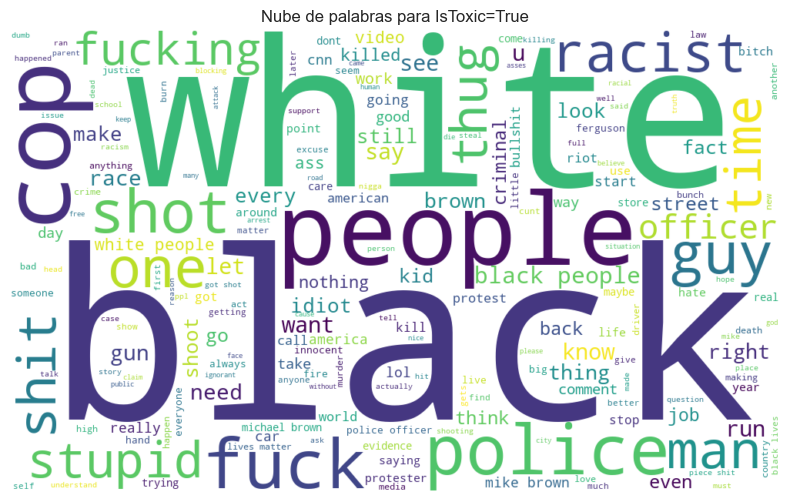

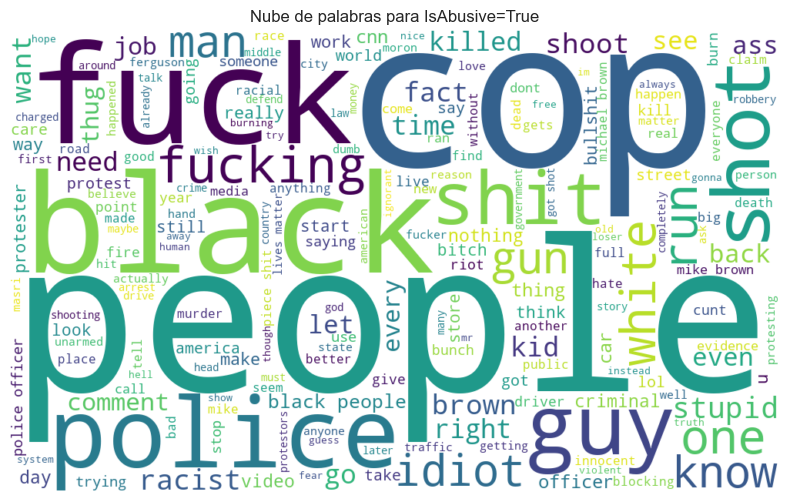

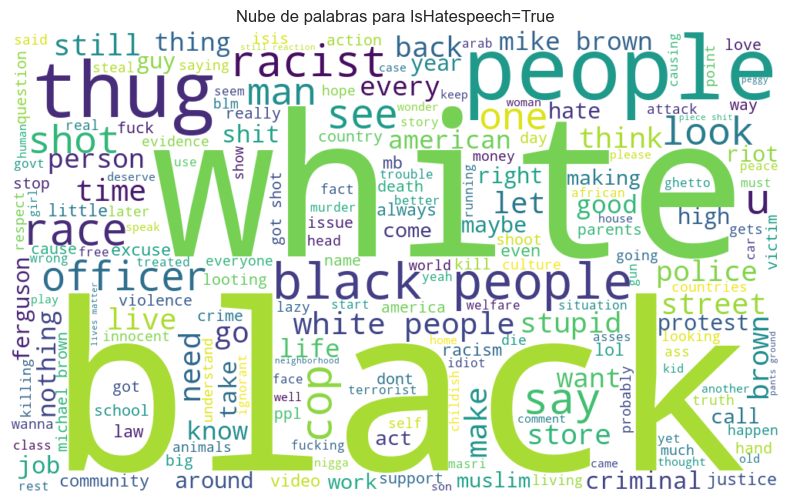

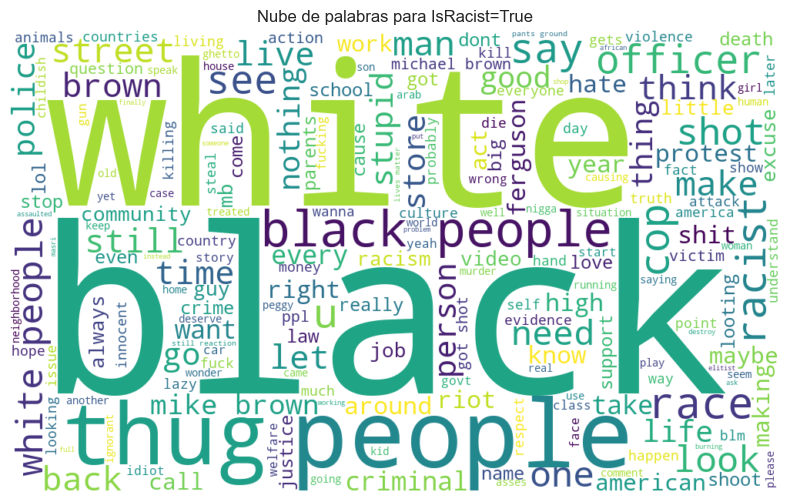


### 11. Resultados: nubes de palabras

- En `IsToxic` e `IsAbusive`:
  - Destacan insultos y expresiones agresivas.
- En `IsHatespeech` y `IsRacist`:
  - Destacan términos referidos a grupos raciales y colectivos específicos.

Estas visualizaciones refuerzan lo observado en el análisis de vocabulario y n-gramas:
hay patrones léxicos muy característicos del discurso de odio.


In [11]:
# === 11. Word clouds per label ==============================================

def preprocess_for_cloud(text):
    """Basic cleaning for word cloud: lowercase, remove URLs/punctuation, remove stopwords."""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in english_stopwords]
    return " ".join(tokens)

def plot_wordcloud(tag):
    """Generate and display a word cloud for comments where tag == True."""
    sub = df[df[tag] == True]
    if len(sub) == 0:
        print(f"No positive examples for {tag}.")
        return
    
    text_all = " ".join(sub["Text"].apply(preprocess_for_cloud))
    
    # Create word cloud
    wc = WordCloud(
        width=1000,
        height=600,
        background_color="white"
    ).generate(text_all)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube de palabras para {tag}=True")
    plt.show()

for tag in ["IsToxic", "IsAbusive", "IsHatespeech", "IsRacist"]:
    plot_wordcloud(tag)

# Markdown explanation
display(Markdown(r"""
### 11. Resultados: nubes de palabras

- En `IsToxic` e `IsAbusive`:
  - Destacan insultos y expresiones agresivas.
- En `IsHatespeech` y `IsRacist`:
  - Destacan términos referidos a grupos raciales y colectivos específicos.

Estas visualizaciones refuerzan lo observado en el análisis de vocabulario y n-gramas:
hay patrones léxicos muy característicos del discurso de odio.
"""))


### 12. Resumen ejecutivo del EDA

Para cerrar, resumimos los principales hallazgos del análisis exploratorio y cómo afectan
al diseño del pipeline de preprocesado y modelado.


In [12]:
# === 12. Final EDA summary ===================================================

n_total = len(df)
n_videos = df["VideoId"].nunique()
n_unique_text = n_total - df["Text"].duplicated().sum()
hate_total = df["AnyToxic"].sum()
no_hate_total = n_total - hate_total
hate_pct = hate_total / n_total * 100

display(Markdown(rf"""
## 12. Resumen ejecutivo del EDA

**Tamaño y estructura**

- Comentarios totales: **{n_total}**
- Comentarios con texto único: **{n_unique_text}**
- Vídeos distintos: **{n_videos}**
- Columnas: IDs, texto (`Text`) y múltiples etiquetas binarias `Is...`.

**Calidad de datos**

- Sin valores nulos.
- Sin filas completamente duplicadas.
- Sólo unos pocos textos duplicados → los eliminaremos en el preprocesado.

**Distribución de clases**

- Comentarios con al menos una etiqueta de odio (`AnyToxic=1`):  
  **{hate_total}** (**{hate_pct:.2f}%**).
- Comentarios sin etiquetas de odio (`AnyToxic=0`):  
  **{no_hate_total}** (**{100 - hate_pct:.2f}%**).
- Problema claramente **multi-label**: muchos comentarios tienen 2–3 etiquetas a la vez.

**Etiquetas útiles vs problemáticas**

- Frecuentes y aprovechables para modelado:
  - `IsToxic`, `IsAbusive`, `IsProvocative`, `IsHatespeech`,
    `IsRacist`, `IsObscene`, `IsThreat`, `IsReligiousHate`.
- Con muy pocos positivos:
  - `IsHomophobic`, `IsRadicalism`, `IsSexist`, `IsNationalist`.  
  → Difíciles de modelar de forma independiente.

**Texto y estilo**

- Longitud media moderada (la mayoría < 50 palabras).
- Comentarios tóxicos ligeramente más largos que los no tóxicos.
- Rasgos de estilo:
  - Mayor uso de mayúsculas y exclamaciones en comentarios tóxicos.
  - Muchas más palabras de odio explícitas.

**Correlaciones y contexto**

- Fuerte correlación entre `IsHatespeech` y `IsRacist`:
  - Racismo como subtipo de hate speech.
- `IsToxic` correlaciona fuertemente con `IsAbusive`.
- Gran variación de toxicidad por vídeo:
  - Vídeos muy tóxicos vs vídeos relativamente “limpios”.
  - Es recomendable controlar `VideoId` al hacer train/test split.

**Vocabulario y n-gramas**

- Léxico centrado en raza, policía y conflicto social.
- N-gramas como *black people*, *white people*, *piece of shit*, *run them over* son muy característicos.
- Justifica el uso de **TF-IDF con uni/bi-gramas** en el pipeline clásico.

---

### Impacto en el preprocesado y el modelado

En el siguiente notebook de **preprocesado**:

- Eliminaremos duplicados de texto.
- Crearemos dos columnas de texto procesado:
  - `text_basic`: limpieza suave, pensada para **modelos modernos** (transformers).
  - `text_classic`: normalización + stopwords + lematización, pensada para **modelos clásicos**.
- Añadiremos features numéricas derivadas del EDA:
  - Longitud (palabras, caracteres).
  - Rasgos de estilo (mayúsculas, exclamaciones, palabras de odio).
- Seleccionaremos las etiquetas con suficientes ejemplos para entrenar modelos robustos.

Con este EDA tenemos una visión clara del dataset y una base sólida para diseñar el pipeline completo.
"""))



## 12. Resumen ejecutivo del EDA

**Tamaño y estructura**

- Comentarios totales: **1000**
- Comentarios con texto único: **997**
- Vídeos distintos: **13**
- Columnas: IDs, texto (`Text`) y múltiples etiquetas binarias `Is...`.

**Calidad de datos**

- Sin valores nulos.
- Sin filas completamente duplicadas.
- Sólo unos pocos textos duplicados → los eliminaremos en el preprocesado.

**Distribución de clases**

- Comentarios con al menos una etiqueta de odio (`AnyToxic=1`):  
  **462** (**46.20%**).
- Comentarios sin etiquetas de odio (`AnyToxic=0`):  
  **538** (**53.80%**).
- Problema claramente **multi-label**: muchos comentarios tienen 2–3 etiquetas a la vez.

**Etiquetas útiles vs problemáticas**

- Frecuentes y aprovechables para modelado:
  - `IsToxic`, `IsAbusive`, `IsProvocative`, `IsHatespeech`,
    `IsRacist`, `IsObscene`, `IsThreat`, `IsReligiousHate`.
- Con muy pocos positivos:
  - `IsHomophobic`, `IsRadicalism`, `IsSexist`, `IsNationalist`.  
  → Difíciles de modelar de forma independiente.

**Texto y estilo**

- Longitud media moderada (la mayoría < 50 palabras).
- Comentarios tóxicos ligeramente más largos que los no tóxicos.
- Rasgos de estilo:
  - Mayor uso de mayúsculas y exclamaciones en comentarios tóxicos.
  - Muchas más palabras de odio explícitas.

**Correlaciones y contexto**

- Fuerte correlación entre `IsHatespeech` y `IsRacist`:
  - Racismo como subtipo de hate speech.
- `IsToxic` correlaciona fuertemente con `IsAbusive`.
- Gran variación de toxicidad por vídeo:
  - Vídeos muy tóxicos vs vídeos relativamente “limpios”.
  - Es recomendable controlar `VideoId` al hacer train/test split.

**Vocabulario y n-gramas**

- Léxico centrado en raza, policía y conflicto social.
- N-gramas como *black people*, *white people*, *piece of shit*, *run them over* son muy característicos.
- Justifica el uso de **TF-IDF con uni/bi-gramas** en el pipeline clásico.

---

### Impacto en el preprocesado y el modelado

En el siguiente notebook de **preprocesado**:

- Eliminaremos duplicados de texto.
- Crearemos dos columnas de texto procesado:
  - `text_basic`: limpieza suave, pensada para **modelos modernos** (transformers).
  - `text_classic`: normalización + stopwords + lematización, pensada para **modelos clásicos**.
- Añadiremos features numéricas derivadas del EDA:
  - Longitud (palabras, caracteres).
  - Rasgos de estilo (mayúsculas, exclamaciones, palabras de odio).
- Seleccionaremos las etiquetas con suficientes ejemplos para entrenar modelos robustos.

Con este EDA tenemos una visión clara del dataset y una base sólida para diseñar el pipeline completo.
